In [47]:
"""
Zachary Katz
zachary_katz@mines.edu
19 November 2025

Programmatically download one granule of SWOT_LR_SSH data over the Canadian Arctic Archipelago.
"""

# Imports and Extensions
import os
import numpy as np

import xarray as xr
import earthaccess

from pathlib import Path

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs

# User-defined Parameters
download_path = './_Data/SWOT_LR_SSH' # Storage location of SWOT granule
os.makedirs(download_path, exist_ok=True)

gran_name = 'SWOT_L2_LR_SSH_Expert_041_380_20251115T083521_20251115T092649_PID0_01.nc' # Name of granule to download
# I chose the expert product for this example, but unsmoothed offers a higher spatial resolution
# I got this from Earthdata search, under the 'Data Access' tab on podaac (https://podaac.jpl.nasa.gov/dataset/SWOT_L2_LR_SSH_Expert_D)
# This podaac landing page has other useful information such as links to the product description documents.
# Alternatively, you can search by spatial and/or temporal extent instead of finding a specific granule name.


In [49]:
# Download SWOT data 
earthaccess.login() # Uses .netrc if available; falls back to interactive login. (https://earthaccess.readthedocs.io/en/latest/howto/authenticate/)
karin_results = earthaccess.search_data(short_name = 'SWOT_L2_LR_SSH_D', 
                                        granule_name = gran_name)
earthaccess.download(karin_results, download_path, provider='POCLOUD')
granules = list(Path(download_path).glob('SWOT_L2_LR*.nc'))

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 467.33it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.06s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 5769.33it/s]


In [50]:
# Load SWOT data
granule = granules[0]
ds = xr.open_mfdataset(granule, combine='nested', concat_dim="num_lines", decode_times=False)
lon = ds["longitude"].data
lat = ds["latitude"].data
ssh = ds["ssh_karin_2"].data
ssha = ds['ssha_karin_2'].data
corr= ds["height_cor_xover"].data
corrected_ssh = ssh + corr # Must manually apply crossover correction when using LR products!
corrected_ssha = ssha + corr

ds # Show xarray dataset

<xarray.Dataset> Size: 400MB
Dimensions:                                (num_lines: 9866, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    longitude                              (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    latitude_nadir                         (num_lines) float64 79kB dask.array<chunksize=(9866,), meta=np.ndarray>
    longitude_nadir                        (num_lines) float64 79kB dask.array<chunksize=(9866,), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/99)
    time                                   (num_lines) float64 79kB dask.array<chunksize=(9866,), meta=np.ndarray>
    time_tai                               (num_lines) float64 79kB dask.array<chunksize=(9866,), meta=np.ndarray>
    ssh_karin                              (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ssh_karin_qual                         (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ssh_karin_uncert                       (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ssha_karin                             (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ...                                     ...
    swh_ssb_cor_source                     (num_lines, num_pixels) float32 3MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    swh_ssb_cor_source_2                   (num_lines, num_pixels) float32 3MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    wind_speed_ssb_cor_source              (num_lines, num_pixels) float32 3MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    wind_speed_ssb_cor_source_2            (num_lines, num_pixels) float32 3MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    volumetric_correlation                 (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    volumetric_correlation_uncert          (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
Attributes: (12/62)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    institution:                                   CNES
    source:                                        Ka-band radar interferometer
    history:                                       2025-11-17T23:19:29Z : Cre...
    platform:                                      SWOT
    ...                                            ...
    ellipsoid_semi_major_axis:                     6378137.0
    ellipsoid_flattening:                          0.0033528106647474805
    good_ocean_data_percent:                       64.97172660431396
    ssha_variance:                                 1.4429501332483452
    references:                                    V1.4.1
    equator_longitude:                             -46.04

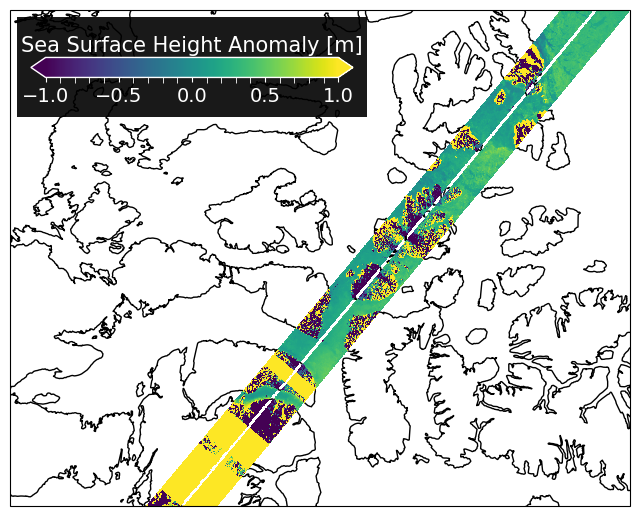

In [52]:
# Plot elevation
# The horizontal bands of high ssha are where land has been masked out of the product
# Play with the colorbar limits and axes limits to better see the sea surface height.

# Plotting setup
label = "Sea Surface Height Anomaly [m]" # Plot label
vmin = -1
vmax = 1
bbox = [-2500000,-400000,-1000000,800000] # Bounding box

ps71_projection = ccrs.Stereographic(central_latitude=90, central_longitude=0, true_scale_latitude=71) # North polar stereo
fig, ax = plt.subplots(
    subplot_kw={'projection': ps71_projection},
    figsize=(8,8)
)
ax.coastlines(resolution='10m', linewidth=1, color='black')



# Plot SWOT Raster
mesh = ax.pcolormesh(
    lon, lat, corrected_ssha,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    vmin=vmin,vmax=vmax, 
    zorder=2,        
)

ax.set_xlim(bbox[0],bbox[2])
ax.set_ylim(bbox[1],bbox[3])



# Colorbar axes setup
k_cbar_anchor = (0, 0.999)
cbbox = inset_axes(ax, width=3.5,height=1,
                bbox_to_anchor=k_cbar_anchor,
                bbox_transform=ax.transAxes, loc="upper left")
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.tick_params(
    axis = 'both',
    left = False,
    top = False,
    right = False,
    bottom = False,
    labelleft = False,
    labeltop = False,
    labelright = False,
    labelbottom = False
)
cbbox.set_facecolor([0,0,0,0.9])

cbaxes = inset_axes(cbbox, '92%', '20%', loc = 'center')
cbar=fig.colorbar(mesh,cax=cbaxes, orientation='horizontal',extend='both') #make colorbar
cbar.outline.set_edgecolor('white')
cbar.outline.set_linewidth(1)
cbar.ax.tick_params(labelsize=14, color='white', labelcolor='white')
cbar.set_label(label, fontsize=15, color='white')
cbar.ax.xaxis.set_label_position('top')

cbar.ax.minorticks_on()

cbar.ax.tick_params(which='minor', length=4, color='white')

fig.savefig('./Output/SWOT_LR_SSHA.png', dpi=300, bbox_inches='tight')